# Udacity DRL Project 1 Report: Navigation in Banana World

### Introduction

For this project, you will train an agent to navigate (and collect bananas!) in a Unity Agents world.  

A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.  
Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.  

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  Given this information, the agent has to learn how to best select actions.  

Four discrete actions are available, corresponding to:
- **`0`** - move forward.
- **`1`** - move backward.
- **`2`** - turn left.
- **`3`** - turn right.

#### Benchmark
The task is 
episodic, and in order to solve the environment, your agent must get an average score of +13 over 100 consecutive episodes.

#### References and Resources

Textbook

Paper

https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution

## Variable and Hyperparameter Settings


In [ ]:
import numpy as np
import zipfile
import os

## Environment Initialization

---

### Initialize Custom Banana-world Unity Environment

*(per project directions)*

In [ ]:
!pip -q install ./python
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="/Data/Banana_Linux/Banana.x86_64")

If necessary in case that doesn't work:

### Unzip, Import and Install from Local Environment Files

**Note: Running the following two cells is probably not necessary for project evaluation!**

In [ ]:
with zipfile.ZipFile("unity_python.zip") as zip_ref:
    zip_ref.extractall()
!pip -q install ./python   #./unity_python
from unityagents import UnityEnvironment

In [ ]:
with zipfile.ZipFile('Banana_Linux.zip') as zip_ref:
    zip_ref.extractall()
!chmod -R 755 Banana_Linux
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

### Set Up the Banana Environment 

In [ ]:
# Load the banana brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print(brain)

# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Agent Information
print("Agents: ", len(env_info.agents))

# Action Space
action_size = brain.vector_action_space_size
print("Actions: ", action_size))

# State Space 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
print("State size: ", state_size))

# State observation and Unity environment syntax
score = 0                                          # initialize the score
action = np.random.randint(action_size)            # select a (random) action
env_info = env.step(action)[brain_name]            # send the action to the environment
next_state = env_info.vector_observations[0]       # get the next state
reward = env_info.rewards[0]                       # get the reward
done = env_info.local_done[0]                      # see if episode has finished

print("\nAction: {}\nNext State:\n{}\nReward: {}\nDone: {}".format(state, action, reward, done))  

## Design

- QNetworks
- Learn
- Step
- Loss
- Replay memory

#### QNetworks and Models

Train the provided Agent model to solve the environment!  

A few **important notes**:
- Agent Structre
- DQN Design and Mods w/ questions

And:

```
### These class definitions are identical to those provided
### in the solution folder for the DQN coding exercise
### https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution

###Agent Learn line 105
# Compute Q targets for current states 
# Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

#### Is the (1-dones) term there because predicted rewards
#### should always be 0 for terminal state...?
#### Are there ever any dones...?
```


In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor used by Mnih et al. (2015)
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 8        # how often to update the network, originally 4

MAX_T = 301             # Max steps per episode; environment default is 300
fc_units = 64           # Mnih et al. (2015) used 32 in their model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

#### Deep Q-Network Learning Algorithm "*DQN*"

Modifications:

- small changes in syntax to interact with this environment
- epsilon decays *linearly* at default rate of 0.001/episode
- specify the Agent model to be trained

In [ ]:
### This dqn algorithm is slightly modified from the one provided
### in the solution folder for the DQN coding exercise.
### The difference is mostly the change in syntax for interacting 
### with the UnityAgents environment, as provided in the p1 Navigation
### notebook.
### https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.1, eps_step=1e-3):
    """The Deep Q-Learning algorithm from the DQN solution folder, with some minor changes:
           - small changes in syntax to interact with this environment
           - epsilon decays **linearly**
           - the Agent model to be trained must be specified  
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_step (float): linear factor for decreasing epsilon (per episode)
    """
    
    scores = []                        # list containing scores from each episode
    window_size = 100                  # scores to rolling-remember
    scores_window = deque(maxlen=window_size)
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        #### Changes from provided DQN code for using UnityAgents syntax:
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                 # epsilon-greedy action choice
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
        #### ^^^ End of syntax changes^^^
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps-eps_step)  # decrease epsilon LINEARLY to eps_end
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps))
        if np.mean(scores_window)>17.0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps))
            print('\n\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'solved_weights.pth')
            break
    return scores

## Training


In [ ]:
# Initialize an agent
agent = Agent(state_size, action_size, seed=10)

# Run DQN Training
scores = dqn(agent, n_episodes=1200, max_t=1000, 
             eps_start=0.1, eps_end=0.005, eps_step=0.001)

Episode 100	Average Score: 3.84	Epsilon: 0.01
Episode 200	Average Score: 9.64	Epsilon: 0.01
Episode 300	Average Score: 12.81	Epsilon: 0.01
Episode 400	Average Score: 13.67	Epsilon: 0.01
Episode 500	Average Score: 15.59	Epsilon: 0.01
Episode 600	Average Score: 16.30	Epsilon: 0.01
Episode 700	Average Score: 16.65	Epsilon: 0.01
Episode 726	Average Score: 17.02	Epsilon: 0.01


Environment solved in 726 episodes!	Average Score: 17.02


In [ ]:
# High scoreer --- Solved in 681, eps_decay=0.995, UPDATE_EVERY = 10
agent681 = Agent(state_size, action_size, seed=10)
agent681.qnetwork_local.load_state_dict(torch.load('highpoint.pth'))

## Results

Benchmark score is an average reward (over 100 episodes) of at least +13 in less than 1800 episodes.


In [ ]:
mean_scores = []
for i in np.arange(1,len(scores)):
    if i < 100:
        mean_score = np.mean(scores[:i])
    else:
        mean_score = np.mean(scores[i-100:i])       
    mean_scores.append(mean_score)


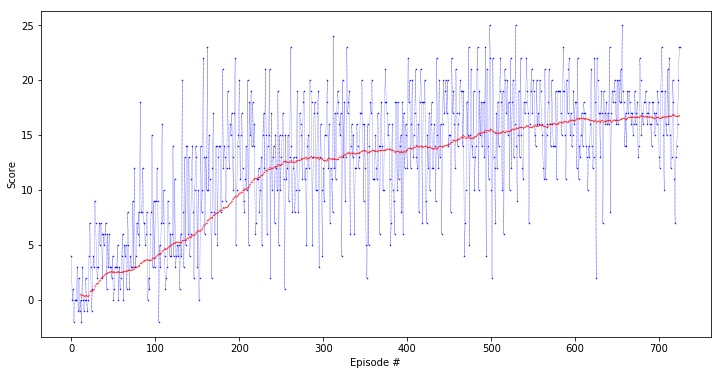

In [ ]:
# plot the scores
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, 'bo--', linewidth=0.25, markersize=0.5,)
plt.plot(np.arange(10, len(mean_scores)), mean_scores[10:], 'ro-', linewidth=0.25, markersize=0.25,)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
#env.close()

## Further Study

## Appendix I: Additional Data